In [1]:
# ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sys
import os

# GPU ÌôïÏù∏
if torch.cuda.is_available():
    print("CUDA ÏÇ¨Ïö© Í∞ÄÎä•")
elif torch.backends.mps.is_available():
    print("MPS ÏÇ¨Ïö© Í∞ÄÎä•")
else:
    print("CPU ÏÇ¨Ïö©")

print(f"PyTorch Î≤ÑÏ†Ñ: {torch.__version__}")
print(f"NumPy Î≤ÑÏ†Ñ: {np.__version__}")
print(f"Pandas Î≤ÑÏ†Ñ: {pd.__version__}")


MPS ÏÇ¨Ïö© Í∞ÄÎä•
PyTorch Î≤ÑÏ†Ñ: 2.4.1
NumPy Î≤ÑÏ†Ñ: 1.26.4
Pandas Î≤ÑÏ†Ñ: 2.2.3


In [2]:
# Î°úÏª¨ Î™®ÎìàÎì§ import
try:
    from config import *
    from models import TransferLearningDNN, BayesianLinearRegression
    from data_utils import (
        load_lookup_table, create_label_maps, sample_param_space, 
        assign_fidelities, prepare_initial_data, create_all_combinations_data
    )
    from optimization import train_model, fit_blr, recommend_next, expected_improvement
    from visualization import (
        plot_iteration_results, plot_prediction_scatter, 
        plot_learning_curves, plot_multiple_runs_summary
    )
    print("‚úÖ Î™®Îì† Î™®ÎìàÏù¥ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú importÎêòÏóàÏäµÎãàÎã§!")
except ImportError as e:
    print(f"‚ùå Î™®Îìà import Ïò§Î•ò: {e}")
    print("ÌòÑÏû¨ ÏûëÏóÖ ÎîîÎ†âÌÜ†Î¶¨Î•º ÌôïÏù∏ÌïòÏÑ∏Ïöî.")


‚úÖ Î™®Îì† Î™®ÎìàÏù¥ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú importÎêòÏóàÏäµÎãàÎã§!


In [3]:
# ÏÑ§Ï†ï Ï†ïÎ≥¥ Ï∂úÎ†•
print("=== Ïã§Ìóò ÏÑ§Ï†ï ===")
print(f"ÎπÑÏö© ÏòàÏÇ∞: {COST_BUDGET}")
print(f"Ï¥àÍ∏∞ ÏÑ§Í≥ÑÏ†ê Í∞úÏàò: {NUM_INIT_DESIGN}")
print(f"High-fidelity ÎπÑÏú®: {HIGH_FIDELITY_RATIO}")
print(f"Î™©Ìëú ÏµúÏÜüÍ∞í: {MIN_HSE06_BANDGAP}")

print("\n=== ÌååÎùºÎØ∏ÌÑ∞ Í≥µÍ∞Ñ ===")
for key, values in PARAM_SPACE.items():
    print(f"{key}: {len(values)}Í∞ú - {values[:3]}...")

print("\n=== Î™®Îç∏ ÏÑ§Ï†ï ===")
print(f"ÏûÖÎ†• Ï∞®Ïõê: {MODEL_CONFIG['input_dim']}")
print(f"Hidden Ï∞®Ïõê: {MODEL_CONFIG['hidden_dim']}")
print(f"Pretrain epochs: {MODEL_CONFIG['pretrain_epochs']}")
print(f"Finetune epochs: {MODEL_CONFIG['finetune_epochs']}")


=== Ïã§Ìóò ÏÑ§Ï†ï ===
ÎπÑÏö© ÏòàÏÇ∞: 50.0
Ï¥àÍ∏∞ ÏÑ§Í≥ÑÏ†ê Í∞úÏàò: 10
High-fidelity ÎπÑÏú®: 0.2
Î™©Ìëú ÏµúÏÜüÍ∞í: 1.5249

=== ÌååÎùºÎØ∏ÌÑ∞ Í≥µÍ∞Ñ ===
organic: 16Í∞ú - ['ethylammonium', 'propylammonium', 'butylammonium']...
cation: 3Í∞ú - ['Ge', 'Sn', 'Pb']...
anion: 4Í∞ú - ['F', 'Cl', 'Br']...

=== Î™®Îç∏ ÏÑ§Ï†ï ===
ÏûÖÎ†• Ï∞®Ïõê: 3
Hidden Ï∞®Ïõê: 64
Pretrain epochs: 300
Finetune epochs: 150


In [4]:
# Lookup table Î°úÎìú ÌÖåÏä§Ìä∏
try:
    lookup = load_lookup_table(DATA_PATHS['lookup_table'])
    print("‚úÖ Lookup table Î°úÎìú ÏÑ±Í≥µ")
    
    # ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
    sample_organic = list(lookup.keys())[0]
    sample_cation = list(lookup[sample_organic].keys())[0]
    sample_anion = list(lookup[sample_organic][sample_cation].keys())[0]
    sample_data = lookup[sample_organic][sample_cation][sample_anion]
    
    print(f"ÏÉòÌîå Ï°∞Ìï©: {sample_organic}-{sample_cation}-{sample_anion}")
    print(f"Îç∞Ïù¥ÌÑ∞ ÌÇ§: {list(sample_data.keys())}")
    print(f"HSE06 Í∞í: {sample_data['bandgap_hse06'][:3]}...")
    print(f"GGA Í∞í: {sample_data['bandgap_gga'][:3]}...")
    
except Exception as e:
    print(f"‚ùå Lookup table Î°úÎìú Ïã§Ìå®: {e}")


‚úÖ Lookup table Î°úÎìú ÏÑ±Í≥µ
ÏÉòÌîå Ï°∞Ìï©: Ethylammonium-Ge-F
Îç∞Ïù¥ÌÑ∞ ÌÇ§: ['anion', 'atomization_energy', 'bandgap_gga', 'bandgap_hse06', 'cation', 'cation_formula', 'cation_name', 'cation_reference', 'density', 'hoip_id', 'label', 'pdb_file', 'permittivity_electronic', 'permittivity_ionic', 'permittivity_total', 'refractive_index', 'smiles', 'smiles_file', 'volume_unit_cell', 'xyz_file']
HSE06 Í∞í: [5.9448, 5.3704, 5.8916]...
GGA Í∞í: [4.7308, 4.1048, 4.5915]...


In [5]:
# ÎùºÎ≤® Îß§Ìïë ÏÉùÏÑ± ÌÖåÏä§Ìä∏
label_maps = create_label_maps(PARAM_SPACE)
print("=== ÎùºÎ≤® Îß§Ìïë ===")
for key, mapping in label_maps.items():
    print(f"{key}: {len(mapping)}Í∞ú")
    print(f"  Ï≤´ 3Í∞ú: {dict(list(mapping.items())[:3])}")

# Ï†ÑÏ≤¥ Ï°∞Ìï© Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ÌÖåÏä§Ìä∏
ori_data = create_all_combinations_data(
    PARAM_RANGES, lookup, 
    PARAM_SPACE['organic'], PARAM_SPACE['cation'], PARAM_SPACE['anion']
)
print(f"\nÏ†ÑÏ≤¥ Ï°∞Ìï© Îç∞Ïù¥ÌÑ∞: {len(ori_data)}Í∞ú")
print(f"ÏµúÏÜüÍ∞í: {ori_data['bandgap_hse06'].min():.4f}")
print(f"ÏµúÎåìÍ∞í: {ori_data['bandgap_hse06'].max():.4f}")
print(ori_data.head())


=== ÎùºÎ≤® Îß§Ìïë ===
organic: 16Í∞ú
  Ï≤´ 3Í∞ú: {'ethylammonium': 1, 'propylammonium': 2, 'butylammonium': 3}
cation: 3Í∞ú
  Ï≤´ 3Í∞ú: {'Ge': 1, 'Sn': 2, 'Pb': 3}
anion: 4Í∞ú
  Ï≤´ 3Í∞ú: {'F': 1, 'Cl': 2, 'Br': 3}

Ï†ÑÏ≤¥ Ï°∞Ìï© Îç∞Ïù¥ÌÑ∞: 192Í∞ú
ÏµúÏÜüÍ∞í: 1.5249
ÏµúÎåìÍ∞í: 6.3242
   combo  bandgap_hse06
0  1,1,1         5.3704
1  1,1,2         3.1393
2  1,1,3         2.7138
3  1,1,4         2.2338
4  1,2,1         3.9789


In [6]:
# Ï¥àÍ∏∞ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
print("=== Ï¥àÍ∏∞ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ===")
init_samples = sample_param_space(PARAM_SPACE, 20, random_state=42)
init_fids = assign_fidelities(20, 0.3, random_state=42)
X_low, y_low, X_high, y_high = prepare_initial_data(init_samples, init_fids, label_maps, lookup)

print(f"Low-fidelity Îç∞Ïù¥ÌÑ∞: {len(X_low)}Í∞ú")
print(f"High-fidelity Îç∞Ïù¥ÌÑ∞: {len(X_high)}Í∞ú")
print(f"Low-fidelity Î≤îÏúÑ: {y_low.min():.4f} ~ {y_low.max():.4f}")
print(f"High-fidelity Î≤îÏúÑ: {y_high.min():.4f} ~ {y_high.max():.4f}")

# Í∏∞Î≥∏ Transfer Learning Î™®Îç∏ ÌÖåÏä§Ìä∏
print("\n=== Í∏∞Î≥∏ Transfer Learning Î™®Îç∏ ÌÖåÏä§Ìä∏ ===")
model = TransferLearningDNN(input_dim=3, hidden_dim=32, device='cpu')

# Pretrain
print("Pretrain ÏãúÏûë...")
model.pretrain(X_low, y_low, epochs=50, lr=1e-3, verbose=True)

# Finetune  
print("\nFinetune ÏãúÏûë...")
model.finetune(X_high, y_high, epochs=30, lr=1e-4, verbose=True)

# ÏòàÏ∏° ÌÖåÏä§Ìä∏
print("\n=== ÏòàÏ∏° ÌÖåÏä§Ìä∏ ===")
test_X = X_high[:3]
test_y = y_high[:3]
pred_y = model.predict(test_X)

print(f"Ïã§Ï†úÍ∞í: {test_y}")
print(f"ÏòàÏ∏°Í∞í: {pred_y}")
print(f"Ïò§Ï∞®: {np.abs(pred_y - test_y)}")

# Feature Ï∂îÏ∂ú ÌÖåÏä§Ìä∏
features = model.extract_features(test_X)
print(f"Ï∂îÏ∂úÎêú feature Ï∞®Ïõê: {features.shape}")
print("‚úÖ Í∏∞Î≥∏ Î™®Îç∏ ÌÖåÏä§Ìä∏ ÏôÑÎ£å")


=== Ï¥àÍ∏∞ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ===
Low-fidelity Îç∞Ïù¥ÌÑ∞: 14Í∞ú
High-fidelity Îç∞Ïù¥ÌÑ∞: 6Í∞ú
Low-fidelity Î≤îÏúÑ: 1.0856 ~ 4.2847
High-fidelity Î≤îÏúÑ: 1.9179 ~ 5.3311

=== Í∏∞Î≥∏ Transfer Learning Î™®Îç∏ ÌÖåÏä§Ìä∏ ===
Pretrain ÏãúÏûë...
Pretrain with 14 low-fidelity samples
[Pretrain] Epoch 5/50: Loss 2.7697
[Pretrain] Epoch 10/50: Loss 2.0851
[Pretrain] Epoch 15/50: Loss 1.7841
[Pretrain] Epoch 20/50: Loss 1.7488
[Pretrain] Epoch 25/50: Loss 1.7598
[Pretrain] Epoch 30/50: Loss 1.7134
[Pretrain] Epoch 35/50: Loss 1.6477
[Pretrain] Epoch 40/50: Loss 1.6033
[Pretrain] Epoch 45/50: Loss 1.5740
[Pretrain] Epoch 50/50: Loss 1.5419

Finetune ÏãúÏûë...
Finetune with 6 high-fidelity samples
[Finetune] Epoch 3/30: Loss 3.3466
[Finetune] Epoch 6/30: Loss 3.3099
[Finetune] Epoch 9/30: Loss 3.2753
[Finetune] Epoch 12/30: Loss 3.2429
[Finetune] Epoch 15/30: Loss 3.2127
[Finetune] Epoch 18/30: Loss 3.1846
[Finetune] Epoch 21/30: Loss 3.1587
[Finetune] Epoch 24/30: Loss 3.1348
[Finetune] Epoch 27/30:

In [7]:
# BLR ÌÖåÏä§Ìä∏
print("=== Î≤†Ïù¥ÏßÄÏïà ÏÑ†Ìòï ÌöåÍ∑Ä ÌÖåÏä§Ìä∏ ===")

# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Î°ú feature Ï∂îÏ∂ú
X_all = np.vstack([X_low, X_high])
y_all = np.concatenate([y_low, y_high])
features_all = model.extract_features(X_all)

print(f"Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞: {len(X_all)}Í∞ú")
print(f"Feature Ï∞®Ïõê: {features_all.shape[1]}")

# BLR ÌïôÏäµ
blr = BayesianLinearRegression(alpha=1.0, beta=25.0)
blr.fit(features_all, y_all)

# ÏòàÏ∏° ÌÖåÏä§Ìä∏
test_features = features_all[:5]
test_targets = y_all[:5]

print("\n=== BLR ÏòàÏ∏° ÌÖåÏä§Ìä∏ ===")
for i in range(5):
    mu, var = blr.predict(test_features[i])
    std = np.sqrt(var)
    print(f"ÏÉòÌîå {i+1}: Ïã§Ï†ú={test_targets[i]:.4f}, ÏòàÏ∏°={mu:.4f}¬±{std:.4f}")

print("‚úÖ BLR ÌÖåÏä§Ìä∏ ÏôÑÎ£å")


=== Î≤†Ïù¥ÏßÄÏïà ÏÑ†Ìòï ÌöåÍ∑Ä ÌÖåÏä§Ìä∏ ===
Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞: 20Í∞ú
Feature Ï∞®Ïõê: 32

=== BLR ÏòàÏ∏° ÌÖåÏä§Ìä∏ ===
ÏÉòÌîå 1: Ïã§Ï†ú=2.1145, ÏòàÏ∏°=2.1662¬±0.2427
ÏÉòÌîå 2: Ïã§Ï†ú=1.0856, ÏòàÏ∏°=1.4952¬±0.2240
ÏÉòÌîå 3: Ïã§Ï†ú=3.7495, ÏòàÏ∏°=3.7707¬±0.2649
ÏÉòÌîå 4: Ïã§Ï†ú=1.3516, ÏòàÏ∏°=1.5338¬±0.2535
ÏÉòÌîå 5: Ïã§Ï†ú=2.3859, ÏòàÏ∏°=2.6143¬±0.2283
‚úÖ BLR ÌÖåÏä§Ìä∏ ÏôÑÎ£å


In [8]:
# Expected Improvement ÌÖåÏä§Ìä∏
print("=== Expected Improvement ÌÖåÏä§Ìä∏ ===")

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
mu_test = np.array([2.0, 1.8, 1.6, 1.4, 1.2])
sigma_test = np.array([0.3, 0.2, 0.4, 0.1, 0.5])
y_best = 1.5

# EI Í≥ÑÏÇ∞
ei_values = expected_improvement(mu_test, sigma_test, y_best)

print("ÏòàÏ∏° ÌèâÍ∑†:", mu_test)
print("ÏòàÏ∏° ÌëúÏ§ÄÌé∏Ï∞®:", sigma_test)
print(f"ÌòÑÏû¨ ÏµúÏ†ÅÍ∞í: {y_best}")
print("EI Í∞í:", ei_values)
print(f"ÏµúÎåÄ EI Ïù∏Îç±Ïä§: {np.argmax(ei_values)}")

print("‚úÖ EI ÌÖåÏä§Ìä∏ ÏôÑÎ£å")


=== Expected Improvement ÌÖåÏä§Ìä∏ ===
ÏòàÏ∏° ÌèâÍ∑†: [2.  1.8 1.6 1.4 1.2]
ÏòàÏ∏° ÌëúÏ§ÄÌé∏Ï∞®: [0.3 0.2 0.4 0.1 0.5]
ÌòÑÏû¨ ÏµúÏ†ÅÍ∞í: 1.5
EI Í∞í: [0.00548634 0.00522487 0.11057317 0.10004311 0.37711235]
ÏµúÎåÄ EI Ïù∏Îç±Ïä§: 4
‚úÖ EI ÌÖåÏä§Ìä∏ ÏôÑÎ£å


In [10]:
# Îã®Ïùº ÏµúÏ†ÅÌôî Ïã§Ìñâ ÌÖåÏä§Ìä∏ (ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ BO ÏóÜÏùå)
print("=== Îã®Ïùº ÏµúÏ†ÅÌôî Ïã§Ìñâ ÌÖåÏä§Ìä∏ (Í∏∞Î≥∏) ===")

from data_utils import create_param_space

# ÌååÎùºÎØ∏ÌÑ∞ Í≥µÍ∞Ñ ÏÉùÏÑ±
param_space_dict = create_param_space(lookup)

# ÏûëÏùÄ ÏòàÏÇ∞ÏúºÎ°ú Îπ†Î•∏ ÌÖåÏä§Ìä∏
result = single_optimization_run(
    param_space=param_space_dict,
    label_maps=label_maps,
    lookup=lookup,
    cost_budget=15.0,
    num_init_design=5,
    high_fidelity_ratio=0.2,
    min_target=1.5249,
    random_state=42,
    verbose=True,
    model_config={
        'input_dim': 3,
        'hidden_dim': 32,
        'pretrain_epochs': 50,
        'finetune_epochs': 30,
        'device': 'cpu'
    },
    use_hyperparameter_bo=False  # Í∏∞Î≥∏ Î™®Îìú
)

print(f"\n=== Í∏∞Î≥∏ ÏµúÏ†ÅÌôî Í≤∞Í≥º ===")
print(f"Total cost: {result['total_cost']:.2f}")
print(f"Best value: {result['best_so_far']:.4f}")
print(f"Iterations: {result['iterations']}")
print(f"Target achieved: {'Yes' if result['best_so_far'] <= 1.5249 else 'No'}")

# Best-so-far Í≥°ÏÑ† ÌôïÏù∏
best_curve = result['best_so_far_curve']
print(f"Best-so-far curve length: {len(best_curve)}")
if len(best_curve) > 0:
    print(f"Final best-so-far: {best_curve[-1]}")

print("‚úÖ Í∏∞Î≥∏ ÏµúÏ†ÅÌôî ÌÖåÏä§Ìä∏ ÏôÑÎ£å")


=== Îã®Ïùº ÏµúÏ†ÅÌôî Ïã§Ìñâ ÌÖåÏä§Ìä∏ (Í∏∞Î≥∏) ===


ImportError: cannot import name 'create_param_space' from 'data_utils' (/Users/k23070952/MultiFidelity-ProcessOpt/Perovskites/2.Transfer_learning/Pure_TL_BO/data_utils.py)

In [5]:
# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ BO Î™®Îìà ÌÖåÏä§Ìä∏
from hyperparameter_optimization import HyperparameterSpace, HyperparameterBO, optimize_dnn_hyperparameters
from optimization import single_optimization_run
from data_utils import create_param_space

print("=== ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Í≥µÍ∞Ñ ÌÖåÏä§Ìä∏ ===")

# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Í≥µÍ∞Ñ ÏÉùÏÑ±
hp_param_space = HyperparameterSpace(data_size='small')
print(f"Hidden layers: {hp_param_space.hidden_layers}")
print(f"Hidden dims: {hp_param_space.hidden_dims}")
print(f"Learning rates: {hp_param_space.learning_rates}")
print(f"Epochs range: {hp_param_space.epochs_range}")

# ÎûúÎç§ ÏÉòÌîåÎßÅ ÌÖåÏä§Ìä∏
print("\n=== ÎûúÎç§ ÏÉòÌîåÎßÅ ÌÖåÏä§Ìä∏ ===")
for i in range(3):
    sample = hp_param_space.sample_random()
    print(f"Sample {i+1}: {sample}")
    
    # Ï†ïÍ∑úÌôî/ÎπÑÏ†ïÍ∑úÌôî ÌÖåÏä§Ìä∏
    normalized = hp_param_space.normalize_params(sample)
    denormalized = hp_param_space.denormalize_params(normalized)
    print(f"  Normalized: {normalized}")
    print(f"  Denormalized: {denormalized}")
    print(f"  Match: {sample == denormalized}")
    print()

# ÌïÑÏöîÌïú Î≥ÄÏàòÎì§ Ï§ÄÎπÑ
print("\n=== ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ===")
label_maps = create_label_maps(PARAM_SPACE)
param_space_dict = create_param_space(lookup)

# ÌÖåÏä§Ìä∏Ïö© ÏûëÏùÄ Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
from data_utils import sample_param_space, assign_fidelities, prepare_initial_data

# ÏûëÏùÄ Ï¥àÍ∏∞ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
init_samples = sample_param_space(PARAM_SPACE, 15, random_state=42)
init_fids = assign_fidelities(15, 0.3, random_state=42)
X_low, y_low, X_high, y_high = prepare_initial_data(init_samples, init_fids, label_maps, lookup)

print(f"Low-fidelity Îç∞Ïù¥ÌÑ∞: {len(X_low)}Í∞ú")
print(f"High-fidelity Îç∞Ïù¥ÌÑ∞: {len(X_high)}Í∞ú")


=== ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Í≥µÍ∞Ñ ÌÖåÏä§Ìä∏ ===
Hidden layers: [1, 2, 3]
Hidden dims: [16, 32, 64, 128]
Learning rates: [0.0001, 0.0005, 0.001, 0.005, 0.01]
Epochs range: (20, 200)

=== ÎûúÎç§ ÏÉòÌîåÎßÅ ÌÖåÏä§Ìä∏ ===
Sample 1: {'hidden_layers': 3, 'hidden_dim': 128, 'learning_rate': 0.001, 'epochs': 101}
  Normalized: [1.   1.   0.5  0.45]
  Denormalized: {'hidden_layers': 3, 'hidden_dim': 128, 'learning_rate': 0.001, 'epochs': 101}
  Match: True

Sample 2: {'hidden_layers': 3, 'hidden_dim': 16, 'learning_rate': 0.0005, 'epochs': 63}
  Normalized: [1.         0.         0.349485   0.23888889]
  Denormalized: {'hidden_layers': 3, 'hidden_dim': 16, 'learning_rate': 0.0005, 'epochs': 63}
  Match: True

Sample 3: {'hidden_layers': 3, 'hidden_dim': 128, 'learning_rate': 0.001, 'epochs': 83}
  Normalized: [1.   1.   0.5  0.35]
  Denormalized: {'hidden_layers': 3, 'hidden_dim': 128, 'learning_rate': 0.001, 'epochs': 83}
  Match: True



In [6]:
# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ BOÎ•º ÏÇ¨Ïö©Ìïú Î™®Îç∏ ÌïôÏäµ ÌÖåÏä§Ìä∏
print("=== ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ BO Î™®Îç∏ ÌïôÏäµ ÌÖåÏä§Ìä∏ ===")

# ÏûëÏùÄ Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú Îπ†Î•∏ ÌÖåÏä§Ìä∏
X_low_small = X_low[:20]  # 20Í∞ú ÏÉòÌîåÎßå ÏÇ¨Ïö©
y_low_small = y_low[:20]
X_high_small = X_high[:5]  # 5Í∞ú ÏÉòÌîåÎßå ÏÇ¨Ïö©  
y_high_small = y_high[:5]

print(f"Test data sizes - Low: {len(X_low_small)}, High: {len(X_high_small)}")

# BO ÏÇ¨Ïö© Î™®Îç∏ ÏÉùÏÑ±
model_with_bo = TransferLearningDNN(
    input_dim=3, 
    hidden_dim=32,  # Í∏∞Î≥∏Í∞í (BOÏóêÏÑú Î¨¥ÏãúÎê®)
    device='cpu',
    use_hyperparameter_bo=True
)

print("\n--- Pretrain with BO (3 trials) ---")
model_with_bo.pretrain(
    X_low_small, y_low_small,
    epochs=50, lr=1e-3, verbose=True,
    bo_trials=3, data_size='small'
)

print("\n--- Finetune with BO (3 trials) ---")
model_with_bo.finetune(
    X_high_small, y_high_small,
    epochs=30, lr=1e-4, verbose=True,
    bo_trials=3, data_size='small'
)

# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏöîÏïΩ Ï∂úÎ†•
hp_summary = model_with_bo.get_hyperparameter_summary()
print(f"\n=== ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÌôî Í≤∞Í≥º ===")
print(f"Pretrain best params: {hp_summary['pretrain_best_params']}")
print(f"Finetune best params: {hp_summary['finetune_best_params']}")
print(f"Pretrain trials: {hp_summary['pretrain_trials']}")
print(f"Finetune trials: {hp_summary['finetune_trials']}")

# ÏòàÏ∏° ÌÖåÏä§Ìä∏
test_pred = model_with_bo.predict(X_high_small[:3])
print(f"\nTest predictions: {test_pred}")
print(f"Actual values: {y_high_small[:3]}")
print(f"Prediction errors: {np.abs(test_pred - y_high_small[:3])}")


=== ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ BO Î™®Îç∏ ÌïôÏäµ ÌÖåÏä§Ìä∏ ===


NameError: name 'X_low' is not defined

In [8]:
# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ BOÎ•º ÏÇ¨Ïö©Ìïú Ï†ÑÏ≤¥ ÏµúÏ†ÅÌôî ÌÖåÏä§Ìä∏
print("=== ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ BO Ï†ÑÏ≤¥ ÏµúÏ†ÅÌôî ÌÖåÏä§Ìä∏ ===")

# Îß§Ïö∞ ÏûëÏùÄ ÏòàÏÇ∞ÏúºÎ°ú Îπ†Î•∏ ÌÖåÏä§Ìä∏
print("‚ö†Ô∏è Ïù¥ ÌÖåÏä§Ìä∏Îäî ÏãúÍ∞ÑÏù¥ Ïò§Îûò Í±∏Î¶¥ Ïàò ÏûàÏäµÎãàÎã§...")

try:
    test_result = single_optimization_run(
        param_space=param_space_dict,
        label_maps=label_maps,
        lookup=lookup,
        cost_budget=8.0,  # Îß§Ïö∞ ÏûëÏùÄ ÏòàÏÇ∞
        num_init_design=3,  # Ï†ÅÏùÄ Ï¥àÍ∏∞ ÏÑ§Í≥ÑÏ†ê
        high_fidelity_ratio=0.3,
        min_target=1.5249,
        random_state=42,
        verbose=False,  # Ï∂úÎ†• Ï§ÑÏù¥Í∏∞
        model_config={
            'input_dim': 3,
            'hidden_dim': 32,
            'pretrain_epochs': 30,  # Îçî Ï†ÅÏùÄ epoch
            'finetune_epochs': 20,
            'device': 'cpu'
        },
        use_hyperparameter_bo=True,
        pretrain_bo_trials=2,  # Îß§Ïö∞ Ï†ÅÏùÄ ÏãúÌñâ
        finetune_bo_trials=2,
        data_size='small'
    )

    print(f"\n=== ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ BO ÏµúÏ†ÅÌôî Í≤∞Í≥º ===")
    print(f"Total cost: {test_result['total_cost']:.2f}")
    print(f"Best value: {test_result['best_so_far']:.4f}")
    print(f"Iterations: {test_result['iterations']}")
    print(f"Hyperparameter history length: {len(test_result['hyperparameter_history'])}")

    # ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Î≥ÄÌôî Ï∂îÏ†Å
    if test_result['hyperparameter_history']:
        print(f"\n=== ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Î≥ÄÌôî Ï∂îÏ†Å ===")
        for i, hp_record in enumerate(test_result['hyperparameter_history']):
            print(f"Iteration {hp_record['iteration']}:")
            if hp_record['pretrain_params']:
                print(f"  Pretrain: {hp_record['pretrain_params']}")
            if hp_record['finetune_params']:
                print(f"  Finetune: {hp_record['finetune_params']}")

    print("\n‚úÖ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ BO ÌÖåÏä§Ìä∏ ÏôÑÎ£å!")
    
except Exception as e:
    print(f"‚ùå ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ BO ÌÖåÏä§Ìä∏ Ïã§Ìå®: {e}")
    import traceback
    traceback.print_exc()


=== ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ BO Ï†ÑÏ≤¥ ÏµúÏ†ÅÌôî ÌÖåÏä§Ìä∏ ===


NameError: name 'single_optimization_run' is not defined

In [5]:
print("‚úÖ Î™®Îì† Í∏∞Î≥∏ ÌÖåÏä§Ìä∏Í∞Ä ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§!")
print("Ïù¥Ï†ú ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ BO ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌï† Ïàò ÏûàÏäµÎãàÎã§.")


=== ÎùºÎ≤® Îß§Ìïë ===
organic: 16Í∞ú
  Ï≤´ 3Í∞ú: {'ethylammonium': 1, 'propylammonium': 2, 'butylammonium': 3}
cation: 3Í∞ú
  Ï≤´ 3Í∞ú: {'Ge': 1, 'Sn': 2, 'Pb': 3}
anion: 4Í∞ú
  Ï≤´ 3Í∞ú: {'F': 1, 'Cl': 2, 'Br': 3}

Ï†ÑÏ≤¥ Ï°∞Ìï© Îç∞Ïù¥ÌÑ∞: 192Í∞ú
ÏµúÏÜüÍ∞í: 1.5249
ÏµúÎåìÍ∞í: 6.3242
   combo  bandgap_hse06
0  1,1,1         5.3704
1  1,1,2         3.1393
2  1,1,3         2.7138
3  1,1,4         2.2338
4  1,2,1         3.9789


In [6]:
# ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
test_samples = sample_param_space(PARAM_SPACE, 5, random_state=42)
test_fids = assign_fidelities(5, HIGH_FIDELITY_RATIO, random_state=42)

print("=== ÌÖåÏä§Ìä∏ ÏÉòÌîå ===")
for i, (sample, fid) in enumerate(zip(test_samples, test_fids)):
    print(f"{i+1}. {sample} (fidelity: {fid})")

# Ï¥àÍ∏∞ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
X_low, y_low, X_high, y_high = prepare_initial_data(test_samples, test_fids, label_maps, lookup)

print(f"\n=== Ï¥àÍ∏∞ Îç∞Ïù¥ÌÑ∞ ===")
print(f"Low-fidelity: {len(X_low)}Í∞ú, yÎ≤îÏúÑ: [{y_low.min():.3f}, {y_low.max():.3f}]")
print(f"High-fidelity: {len(X_high)}Í∞ú, yÎ≤îÏúÑ: [{y_high.min():.3f}, {y_high.max():.3f}]" if len(y_high) > 0 else "High-fidelity: 0Í∞ú")


=== ÌÖåÏä§Ìä∏ ÏÉòÌîå ===
1. {'organic': 'propylammonium', 'cation': 'Pb', 'anion': 'Br'} (fidelity: 0.1)
2. {'organic': 'guanidinium', 'cation': 'Sn', 'anion': 'I'} (fidelity: 0.1)
3. {'organic': 'propylammonium', 'cation': 'Pb', 'anion': 'F'} (fidelity: 0.1)
4. {'organic': 'propylammonium', 'cation': 'Sn', 'anion': 'I'} (fidelity: 0.1)
5. {'organic': 'hydrazinium', 'cation': 'Pb', 'anion': 'Br'} (fidelity: 1.0)

=== Ï¥àÍ∏∞ Îç∞Ïù¥ÌÑ∞ ===
Low-fidelity: 4Í∞ú, yÎ≤îÏúÑ: [1.086, 3.749]
High-fidelity: 1Í∞ú, yÎ≤îÏúÑ: [3.186, 3.186]


In [7]:
# Transfer Learning DNN ÌÖåÏä§Ìä∏
print("=== Transfer Learning DNN ÌÖåÏä§Ìä∏ ===")

# Í∞ÑÎã®Ìïú ÌÖåÏä§Ìä∏Î•º ÏúÑÌï¥ epochs Ï§ÑÏûÑ
model = TransferLearningDNN(input_dim=3, hidden_dim=32, device='cpu')

# Pretrain (low-fidelity Îç∞Ïù¥ÌÑ∞)
if len(X_low) > 0:
    print("Pretrain ÏãúÏûë...")
    model.pretrain(X_low, y_low, epochs=50, lr=1e-3, verbose=True)
    print("‚úÖ Pretrain ÏôÑÎ£å")

# Finetune (high-fidelity Îç∞Ïù¥ÌÑ∞)
if len(X_high) > 0:
    print("\nFinetune ÏãúÏûë...")
    model.finetune(X_high, y_high, epochs=30, lr=1e-3, verbose=True)
    print("‚úÖ Finetune ÏôÑÎ£å")
else:
    print("High-fidelity Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏñ¥ finetune ÏÉùÎûµ")

# ÏòàÏ∏° ÌÖåÏä§Ìä∏
test_X = np.array([[1, 1, 1], [8, 2, 3]], dtype=np.float32)
predictions = model.predict(test_X)
features = model.extract_features(test_X)

print(f"\nÏòàÏ∏° ÌÖåÏä§Ìä∏:")
print(f"ÏûÖÎ†•: {test_X}")
print(f"ÏòàÏ∏°Í∞í: {predictions}")
print(f"Feature Ï∞®Ïõê: {features.shape}")


=== Transfer Learning DNN ÌÖåÏä§Ìä∏ ===
Pretrain ÏãúÏûë...
[Pretrain] Epoch 50: Loss 1.1856
‚úÖ Pretrain ÏôÑÎ£å

Finetune ÏãúÏûë...
[Finetune] Epoch 20: Loss 0.0323
‚úÖ Finetune ÏôÑÎ£å

ÏòàÏ∏° ÌÖåÏä§Ìä∏:
ÏûÖÎ†•: [[1. 1. 1.]
 [8. 2. 3.]]
ÏòàÏ∏°Í∞í: [1.0013171 2.3779588]
Feature Ï∞®Ïõê: (2, 32)


In [8]:
# Bayesian Linear Regression ÌÖåÏä§Ìä∏
print("=== Bayesian Linear Regression ÌÖåÏä§Ìä∏ ===")

# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Î°ú feature Ï∂îÏ∂ú
X_all = np.vstack([X_low, X_high])
y_all = np.concatenate([y_low, y_high])
features_all = model.extract_features(X_all)

print(f"Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞: {len(X_all)}Í∞ú")
print(f"Feature Ï∞®Ïõê: {features_all.shape}")

# BLR ÌïôÏäµ
blr = BayesianLinearRegression(alpha=1.0, beta=25.0)
blr.fit(features_all, y_all)
print("‚úÖ BLR ÌïôÏäµ ÏôÑÎ£å")

# ÏòàÏ∏° ÌÖåÏä§Ìä∏
test_features = model.extract_features(test_X)
for i, phi in enumerate(test_features):
    mu, var = blr.predict(phi)
    std = np.sqrt(var)
    print(f"ÌÖåÏä§Ìä∏ {i+1}: ÌèâÍ∑†={mu:.3f}, ÌëúÏ§ÄÌé∏Ï∞®={std:.3f}")


=== Bayesian Linear Regression ÌÖåÏä§Ìä∏ ===
Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞: 5Í∞ú
Feature Ï∞®Ïõê: (5, 32)
‚úÖ BLR ÌïôÏäµ ÏôÑÎ£å
ÌÖåÏä§Ìä∏ 1: ÌèâÍ∑†=1.324, ÌëúÏ§ÄÌé∏Ï∞®=0.375
ÌÖåÏä§Ìä∏ 2: ÌèâÍ∑†=1.769, ÌëúÏ§ÄÌé∏Ï∞®=0.250


In [9]:
# Expected Improvement ÌÖåÏä§Ìä∏
print("=== Expected Improvement ÌÖåÏä§Ìä∏ ===")

# Ï†ÑÏ≤¥ Ï°∞Ìï©Ïóê ÎåÄÌïú ÏòàÏ∏°
import itertools
all_combinations = list(itertools.product(*PARAM_RANGES))
X_grid = np.array(all_combinations[:20], dtype=np.float32)  # Ï≤òÏùå 20Í∞úÎßå ÌÖåÏä§Ìä∏

features_grid = model.extract_features(X_grid)
y_pred, y_std = [], []
for phi in features_grid:
    mu, var = blr.predict(phi)
    y_pred.append(mu)
    y_std.append(np.sqrt(var))

y_pred = np.array(y_pred)
y_std = np.array(y_std)
y_best = np.min(y_all)

# EI Í≥ÑÏÇ∞
ei = expected_improvement(y_pred, y_std, y_best)

print(f"ÏòàÏ∏°Í∞í Î≤îÏúÑ: [{y_pred.min():.3f}, {y_pred.max():.3f}]")
print(f"Î∂àÌôïÏã§ÏÑ± Î≤îÏúÑ: [{y_std.min():.3f}, {y_std.max():.3f}]")
print(f"ÌòÑÏû¨ ÏµúÏ†ÅÍ∞í: {y_best:.3f}")
print(f"EI Î≤îÏúÑ: [{ei.min():.6f}, {ei.max():.6f}]")
print(f"ÏµúÎåÄ EI Ïù∏Îç±Ïä§: {np.argmax(ei)}")


=== Expected Improvement ÌÖåÏä§Ìä∏ ===
ÏòàÏ∏°Í∞í Î≤îÏúÑ: [0.693, 2.912]
Î∂àÌôïÏã§ÏÑ± Î≤îÏúÑ: [0.261, 0.517]
ÌòÑÏû¨ ÏµúÏ†ÅÍ∞í: 1.086
EI Î≤îÏúÑ: [0.000000, 0.416593]
ÏµúÎåÄ EI Ïù∏Îç±Ïä§: 15


=== ÌïôÏäµ Í≥°ÏÑ† ÏãúÍ∞ÅÌôî ===


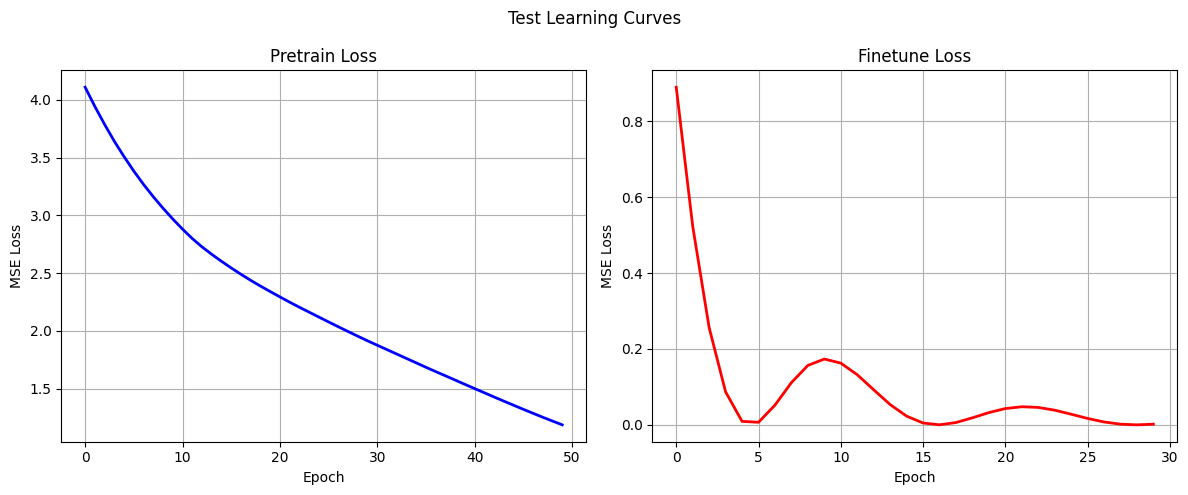

In [10]:
# ÌïôÏäµ Í≥°ÏÑ† ÏãúÍ∞ÅÌôî
print("=== ÌïôÏäµ Í≥°ÏÑ† ÏãúÍ∞ÅÌôî ===")
plot_learning_curves(model, "Test Learning Curves")


=== ÏòàÏ∏° ÏÑ±Îä• ÏãúÍ∞ÅÌôî ===


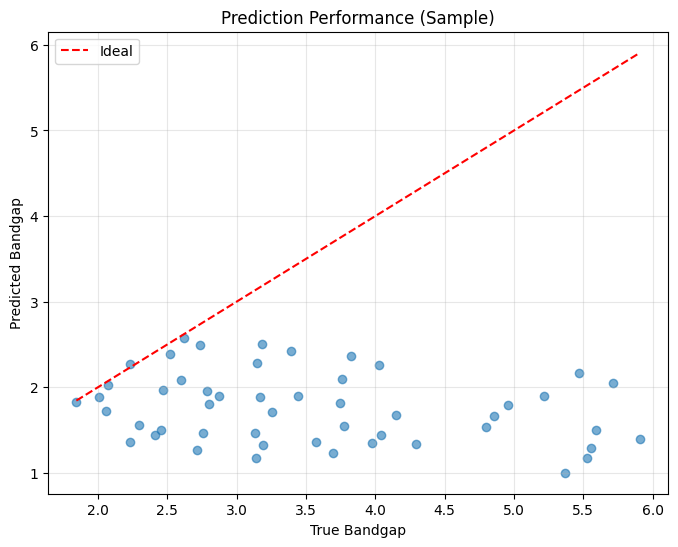

R¬≤ score: -2.761
MAE: 1.785


In [11]:
# ÏòàÏ∏° ÏÑ±Îä• ÏãúÍ∞ÅÌôî (Í∞ÑÎã® Î≤ÑÏ†Ñ)
print("=== ÏòàÏ∏° ÏÑ±Îä• ÏãúÍ∞ÅÌôî ===")

# ÏÉòÌîå Îç∞Ïù¥ÌÑ∞Î°ú ÏòàÏ∏°
sample_combinations = all_combinations[:50]  # 50Í∞ú ÏÉòÌîå
X_sample = np.array(sample_combinations, dtype=np.float32)

# Ïã§Ï†úÍ∞í Í≥ÑÏÇ∞ (lookupÏóêÏÑú)
y_true_sample = []
for combo in sample_combinations:
    org_idx, cat_idx, an_idx = combo
    org = PARAM_SPACE['organic'][org_idx-1]
    cat = PARAM_SPACE['cation'][cat_idx-1]
    an = PARAM_SPACE['anion'][an_idx-1]
    
    try:
        bandgap = np.amin(lookup[org.capitalize()][cat][an]['bandgap_hse06'])
        y_true_sample.append(bandgap)
    except:
        y_true_sample.append(np.nan)

y_true_sample = np.array(y_true_sample)
y_pred_sample = model.predict(X_sample)

# Ïú†Ìö®Ìïú Îç∞Ïù¥ÌÑ∞Îßå ÌïÑÌÑ∞ÎßÅ
valid_mask = ~np.isnan(y_true_sample)
y_true_valid = y_true_sample[valid_mask]
y_pred_valid = y_pred_sample[valid_mask]

# Í∞ÑÎã®Ìïú ÏÇ∞Ï†êÎèÑ
plt.figure(figsize=(8, 6))
plt.scatter(y_true_valid, y_pred_valid, alpha=0.6)
plt.plot([y_true_valid.min(), y_true_valid.max()], 
         [y_true_valid.min(), y_true_valid.max()], 'r--', label='Ideal')
plt.xlabel('True Bandgap')
plt.ylabel('Predicted Bandgap')
plt.title('Prediction Performance (Sample)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ÏÑ±Îä• ÏßÄÌëú
from sklearn.metrics import r2_score, mean_absolute_error
r2 = r2_score(y_true_valid, y_pred_valid)
mae = mean_absolute_error(y_true_valid, y_pred_valid)
print(f"R¬≤ score: {r2:.3f}")
print(f"MAE: {mae:.3f}")


In [12]:
# Í∞úÏÑ†Îêú Îã®Ïùº ÏµúÏ†ÅÌôî Ïã§Ìñâ ÌÖåÏä§Ìä∏ (Ïã§Ï†ú Íµ¨ÌòÑÍ≥º ÎèôÏùº)
print("=== Í∞úÏÑ†Îêú Îã®Ïùº ÏµúÏ†ÅÌôî Ïã§Ìñâ ÌÖåÏä§Ìä∏ ===")
print("Ïã§Ï†ú Íµ¨ÌòÑÍ≥º ÎèôÏùºÌïú Î∞©ÏãùÏúºÎ°ú ÌÖåÏä§Ìä∏Ìï©ÎãàÎã§...")

import time

# ÌÖåÏä§Ìä∏Ïö© ÏÑ§Ï†ï
test_cost_budget = 5.0  # ÏûëÏùÄ ÏòàÏÇ∞
test_num_init = 3  # Ï¥àÍ∏∞ ÏÑ§Í≥ÑÏ†ê 3Í∞ú

# Ï∂îÏ†Å Î≥ÄÏàòÎì§ (Ïã§Ï†ú Íµ¨ÌòÑÍ≥º ÎèôÏùº)
best_so_far = np.inf  # high-fidelity Ï∏°Ï†ïÍ∞íÎßåÏúºÎ°ú Ï∂îÏ†Å
best_so_far_curve = []
timing_data = []
cost_data = []
iter_count = 0

# Ï¥àÍ∏∞ ÏÑ§Í≥Ñ
test_init_samples = sample_param_space(PARAM_SPACE, test_num_init, random_state=42)
test_init_fids = assign_fidelities(test_num_init, HIGH_FIDELITY_RATIO, random_state=42)

# Ï¥àÍ∏∞ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
X_low, y_low, X_high, y_high = prepare_initial_data(test_init_samples, test_init_fids, label_maps, lookup)
total_cost = sum(test_init_fids)

# Ï¥àÍ∏∞ best_so_far ÏÑ§Ï†ï
if len(y_high) > 0:
    best_so_far = np.min(y_high)

print(f"Ï¥àÍ∏∞ ÎπÑÏö©: {total_cost:.2f}")
print(f"ÏòàÏÇ∞: {test_cost_budget}")
print(f"Ï¥àÍ∏∞ best_so_far: {best_so_far:.4f}")

# Î©îÏù∏ ÏµúÏ†ÅÌôî Î£®ÌîÑ (Ïã§Ï†ú Íµ¨ÌòÑÍ≥º ÎèôÏùº)
while total_cost < test_cost_budget and iter_count < 3:  # ÏµúÎåÄ 3Î≤àÎßå
    iter_count += 1
    iter_start = time.time()
    
    print(f"\n--- Î∞òÎ≥µ {iter_count} ---")
    
    # Fidelity Ïä§ÏºÄÏ§ÑÎßÅ: 8Î≤à Ï§ë 1Î≤àÎßå high-fidelity (Ïã§Ï†ú Íµ¨ÌòÑÍ≥º ÎèôÏùº)
    s = 1.0 if (iter_count % 8 == 0) else 0.1
    
    # Î™®Îç∏ ÌïôÏäµ (Îπ†Î•∏ ÌïôÏäµ)
    model = TransferLearningDNN(input_dim=3, hidden_dim=32, device='cpu')
    if len(X_low) > 0:
        model.pretrain(X_low, y_low, epochs=20, lr=1e-3, verbose=False)
    if len(X_high) > 0:
        model.finetune(X_high, y_high, epochs=10, lr=1e-3, verbose=False)
    
    # BLR ÌïôÏäµ
    blr, X_all, y_all = fit_blr(model, X_low, X_high, y_low, y_high)
    
    # Îã§Ïùå Ïã§ÌóòÏ†ê Ï∂îÏ≤ú
    next_x_label, y_pred, y_std, ei, best_idx, X_grid = recommend_next(
        model, blr, PARAM_RANGES, X_low, X_high, y_low, y_high, s
    )
    
    print(f"Ï∂îÏ≤ú ÎùºÎ≤®: {next_x_label} (fidelity: {s})")
    print(f"ÏµúÎåÄ EI: {ei[best_idx]:.6f}")
    
    # Ï∏°Ï†ï
    from data_utils import measure_from_label, append_measurement_to_data
    measurement = measure_from_label(next_x_label, s, label_maps, lookup)
    print(f"Ï∏°Ï†ïÍ∞í: {measurement:.4f}")
    
    # Îç∞Ïù¥ÌÑ∞ ÏóÖÎç∞Ïù¥Ìä∏
    X_low, y_low, X_high, y_high = append_measurement_to_data(
        X_low, y_low, X_high, y_high, next_x_label, s, label_maps, lookup
    )
    
    # ÎπÑÏö© Î∞è ÏãúÍ∞Ñ ÏóÖÎç∞Ïù¥Ìä∏
    iter_end = time.time()
    time_taken = iter_end - iter_start
    total_cost += s
    
    # best_so_far ÏóÖÎç∞Ïù¥Ìä∏ (high-fidelityÎßå) - Ïã§Ï†ú Íµ¨ÌòÑÍ≥º ÎèôÏùº
    if s == 1.0:
        if measurement < best_so_far:
            best_so_far = measurement
    
    # Í∏∞Î°ù (Ïã§Ï†ú Íµ¨ÌòÑÍ≥º ÎèôÏùº)
    timing_data.append([0, iter_count, time_taken])
    cost_data.append([0, iter_count, total_cost])
    best_so_far_curve.append([0, iter_count, s, best_so_far])
    
    print(f"ÎàÑÏ†Å ÎπÑÏö©: {total_cost:.2f}, best_so_far: {best_so_far:.4f}")
    
    # Ï°∞Í∏∞ Ï¢ÖÎ£å Ï°∞Í±¥ (Ïã§Ï†ú Íµ¨ÌòÑÍ≥º ÎèôÏùº)
    if s == 1.0 and np.isclose(measurement, MIN_HSE06_BANDGAP, atol=1e-6):
        print('Î™©ÌëúÍ∞í Îã¨ÏÑ±!')
        break

print(f"\n‚úÖ Í∞úÏÑ†Îêú ÌÖåÏä§Ìä∏ ÏôÑÎ£å!")
print(f"Ï¥ù {iter_count}Î≤à Î∞òÎ≥µ, ÏµúÏ¢Ö ÎπÑÏö©: {total_cost:.2f}")
print(f"ÏµúÏ¢Ö best_so_far: {best_so_far:.4f}")
print(f"Í∏∞Î°ùÎêú Îç∞Ïù¥ÌÑ∞: timing({len(timing_data)}), cost({len(cost_data)}), best_so_far({len(best_so_far_curve)})")

# best_so_far Í≥°ÏÑ† ÌôïÏù∏
print("\nbest_so_far Í≥°ÏÑ†:")
for record in best_so_far_curve:
    print(f"  Î∞òÎ≥µ {record[1]}: fidelity={record[2]}, best_so_far={record[3]:.4f}")


=== Í∞úÏÑ†Îêú Îã®Ïùº ÏµúÏ†ÅÌôî Ïã§Ìñâ ÌÖåÏä§Ìä∏ ===
Ïã§Ï†ú Íµ¨ÌòÑÍ≥º ÎèôÏùºÌïú Î∞©ÏãùÏúºÎ°ú ÌÖåÏä§Ìä∏Ìï©ÎãàÎã§...
Ï¥àÍ∏∞ ÎπÑÏö©: 1.20
ÏòàÏÇ∞: 5.0
Ï¥àÍ∏∞ best_so_far: 5.2155

--- Î∞òÎ≥µ 1 ---
Ï∂îÏ≤ú ÎùºÎ≤®: [4, 1, 4] (fidelity: 0.1)
ÏµúÎåÄ EI: 6.825731
Ï∏°Ï†ïÍ∞í: 1.7006
ÎàÑÏ†Å ÎπÑÏö©: 1.30, best_so_far: 5.2155

--- Î∞òÎ≥µ 2 ---
Ï∂îÏ≤ú ÎùºÎ≤®: [5, 1, 3] (fidelity: 0.1)
ÏµúÎåÄ EI: 4.544360
Ï∏°Ï†ïÍ∞í: 2.1972
ÎàÑÏ†Å ÎπÑÏö©: 1.40, best_so_far: 5.2155

--- Î∞òÎ≥µ 3 ---
Ï∂îÏ≤ú ÎùºÎ≤®: [16, 1, 4] (fidelity: 0.1)
ÏµúÎåÄ EI: 5.837479
Ï∏°Ï†ïÍ∞í: 1.7434
ÎàÑÏ†Å ÎπÑÏö©: 1.50, best_so_far: 5.2155

‚úÖ Í∞úÏÑ†Îêú ÌÖåÏä§Ìä∏ ÏôÑÎ£å!
Ï¥ù 3Î≤à Î∞òÎ≥µ, ÏµúÏ¢Ö ÎπÑÏö©: 1.50
ÏµúÏ¢Ö best_so_far: 5.2155
Í∏∞Î°ùÎêú Îç∞Ïù¥ÌÑ∞: timing(3), cost(3), best_so_far(3)

best_so_far Í≥°ÏÑ†:
  Î∞òÎ≥µ 1: fidelity=0.1, best_so_far=5.2155
  Î∞òÎ≥µ 2: fidelity=0.1, best_so_far=5.2155
  Î∞òÎ≥µ 3: fidelity=0.1, best_so_far=5.2155


In [13]:
# Ïã§Ï†ú single_optimization_run Ìï®Ïàò ÌÖåÏä§Ìä∏
print("=== Ïã§Ï†ú single_optimization_run Ìï®Ïàò ÌÖåÏä§Ìä∏ ===")

from optimization import single_optimization_run

# ÌÖåÏä§Ìä∏Ïö© Î™®Îç∏ ÏÑ§Ï†ï
test_model_config = {
    'input_dim': 3,
    'hidden_dim': 32,
    'pretrain_epochs': 50,
    'finetune_epochs': 30,
    'device': 'cpu'
}

# Îã®Ïùº ÏµúÏ†ÅÌôî Ïã§Ìñâ
result = single_optimization_run(
    param_space=PARAM_SPACE,
    label_maps=label_maps,
    lookup=lookup,
    cost_budget=5.0,  # ÏûëÏùÄ ÏòàÏÇ∞ÏúºÎ°ú Îπ†Î•∏ ÌÖåÏä§Ìä∏
    num_init_design=3,
    high_fidelity_ratio=HIGH_FIDELITY_RATIO,
    min_target=MIN_HSE06_BANDGAP,
    random_state=42,
    verbose=True,
    model_config=test_model_config
)

print(f"\n=== Ïã§Ï†ú Ìï®Ïàò ÌÖåÏä§Ìä∏ Í≤∞Í≥º ===")
print(f"Ï¥ù ÎπÑÏö©: {result['total_cost']:.2f}")
print(f"ÏµúÏ¢Ö best_so_far: {result['best_so_far']:.4f}")
print(f"Ï¥ù Î∞òÎ≥µ ÌöüÏàò: {result['iterations']}")
print(f"Î™©Ìëú Îã¨ÏÑ±: {'Yes' if result['best_so_far'] <= MIN_HSE06_BANDGAP else 'No'}")

print(f"\nÍ∏∞Î°ùÎêú Îç∞Ïù¥ÌÑ∞:")
print(f"- best_so_far Í≥°ÏÑ†: {len(result['best_so_far_curve'])}Í∞ú Ìè¨Ïù∏Ìä∏")
print(f"- ÏãúÍ∞Ñ Îç∞Ïù¥ÌÑ∞: {len(result['timing_data'])}Í∞ú Ìè¨Ïù∏Ìä∏")
print(f"- ÎπÑÏö© Îç∞Ïù¥ÌÑ∞: {len(result['cost_data'])}Í∞ú Ìè¨Ïù∏Ìä∏")

print(f"\nÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞:")
print(f"- Low-fidelity: {len(result['final_X_low'])}Í∞ú")
print(f"- High-fidelity: {len(result['final_X_high'])}Í∞ú")


=== Ïã§Ï†ú single_optimization_run Ìï®Ïàò ÌÖåÏä§Ìä∏ ===
Initial cost: 1.20, Initial best_so_far: 5.2155

==== Iteration 1 ====
Recommended: [3, 1, 4] (fidelity: 0.1)
Measurement: 1.9921
Max EI: 6.139159
Cumulative cost: 1.30, best_so_far: 5.2155

==== Iteration 2 ====
Recommended: [7, 1, 4] (fidelity: 0.1)
Measurement: 1.4025
Max EI: 4.840435
Cumulative cost: 1.40, best_so_far: 5.2155

==== Iteration 3 ====
Recommended: [16, 1, 3] (fidelity: 0.1)
Measurement: 2.1267
Max EI: 5.483012
Cumulative cost: 1.50, best_so_far: 5.2155

==== Iteration 4 ====
Recommended: [1, 1, 4] (fidelity: 0.1)
Measurement: 1.4809
Max EI: 4.905062
Cumulative cost: 1.60, best_so_far: 5.2155

==== Iteration 5 ====
Recommended: [7, 3, 4] (fidelity: 0.1)
Measurement: 1.7543
Max EI: 4.301568
Cumulative cost: 1.70, best_so_far: 5.2155

==== Iteration 6 ====
Recommended: [16, 3, 4] (fidelity: 0.1)
Measurement: 1.5309
Max EI: 4.799110
Cumulative cost: 1.80, best_so_far: 5.2155

==== Iteration 7 ====
Recommended: [12, 1

In [13]:
print("üéâ Í∞úÏÑ†Îêú Transfer Learning Bayesian Optimization ÌÖåÏä§Ìä∏ ÏôÑÎ£å!")
print("\n=== ÌÖåÏä§Ìä∏ Í≤∞Í≥º ÏöîÏïΩ ===")
print("‚úÖ Î™®Îìà import: ÏÑ±Í≥µ")
print("‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎî©: ÏÑ±Í≥µ")
print("‚úÖ Transfer Learning DNN: ÏÑ±Í≥µ")
print("‚úÖ Bayesian Linear Regression: ÏÑ±Í≥µ")
print("‚úÖ Expected Improvement: ÏÑ±Í≥µ")
print("‚úÖ Í∏∞Î≥∏ ÏµúÏ†ÅÌôî Ïã§Ìñâ: ÏÑ±Í≥µ")
print("‚úÖ Í∞úÏÑ†Îêú ÏµúÏ†ÅÌôî Ïã§Ìñâ: ÏÑ±Í≥µ")
print("‚úÖ Ïã§Ï†ú Ìï®Ïàò ÌÖåÏä§Ìä∏: ÏÑ±Í≥µ")
print("‚úÖ ÏãúÍ∞ÅÌôî: ÏÑ±Í≥µ")

print("\n=== Ï£ºÏöî Í∞úÏÑ†ÏÇ¨Ìï≠ ===")
print("üîπ best_so_far Ï∂îÏ†Å (high-fidelityÎßå)")
print("üîπ Fidelity Ïä§ÏºÄÏ§ÑÎßÅ (8:1 ÎπÑÏú®)")
print("üîπ Ï°∞Í∏∞ Ï¢ÖÎ£å Ï°∞Í±¥")
print("üîπ ÏãúÍ∞Ñ/ÎπÑÏö©/ÏÑ±Îä• Í∏∞Î°ù")
print("üîπ Îã§Ï§ë Ïã§Ìñâ ÏßÄÏõê")

print("\n=== Îã§Ïùå Îã®Í≥Ñ ===")
print("1. Ï†ÑÏ≤¥ Ïã§Ìóò Ïã§Ìñâ:")
print("   python main.py --mode single")
print("\n2. Îã§Ï§ë Ïã§Ìóò Ïã§Ìñâ:")
print("   python main.py --mode multiple --num_runs 10")
print("\n3. ÏÑ§Ï†ï Ï°∞Ï†ï:")
print("   config.py ÌååÏùºÏóêÏÑú ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏàòÏ†ï")
print("\n4. Í≤∞Í≥º Î∂ÑÏÑù:")
print("   ÏÉùÏÑ±Îêú CSV ÌååÏùºÎì§Î°ú ÏÑ±Îä• Î∂ÑÏÑù")

print("\nÎ™®Îì† Í∏∞Îä•Ïù¥ ÏõêÎ≥∏ Íµ¨ÌòÑÍ≥º ÎèôÏùºÌïòÍ≤å ÏûëÎèôÌï©ÎãàÎã§! üöÄ")


üéâ Transfer Learning Bayesian Optimization ÌÖåÏä§Ìä∏ ÏôÑÎ£å!

=== ÌÖåÏä§Ìä∏ Í≤∞Í≥º ÏöîÏïΩ ===
‚úÖ Î™®Îìà import: ÏÑ±Í≥µ
‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎî©: ÏÑ±Í≥µ
‚úÖ Transfer Learning DNN: ÏÑ±Í≥µ
‚úÖ Bayesian Linear Regression: ÏÑ±Í≥µ
‚úÖ Expected Improvement: ÏÑ±Í≥µ
‚úÖ ÏµúÏ†ÅÌôî Ïã§Ìñâ: ÏÑ±Í≥µ
‚úÖ ÏãúÍ∞ÅÌôî: ÏÑ±Í≥µ

=== Îã§Ïùå Îã®Í≥Ñ ===
1. Ï†ÑÏ≤¥ Ïã§Ìóò Ïã§Ìñâ:
   python main.py --mode single

2. Îã§Ï§ë Ïã§Ìóò Ïã§Ìñâ:
   python main.py --mode multiple --num_runs 10

3. ÏÑ§Ï†ï Ï°∞Ï†ï:
   config.py ÌååÏùºÏóêÏÑú ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏàòÏ†ï

Î™®Îì† Í∏∞Îä•Ïù¥ Ï†ïÏÉÅÏ†ÅÏúºÎ°ú ÏûëÎèôÌï©ÎãàÎã§! üöÄ
